In [2]:

from explauto import Environment
from explauto import SensorimotorModel

simpleArmEnv = Environment.from_configuration('simple_arm', 'low_dimensional')
#simpleArmModel = SensorimotorModel.from_configuration(simpleArmEnv.conf, 'nearest_neighbor', 'exact')
simpleArmModel = SensorimotorModel.from_configuration(simpleArmEnv.conf, 'NN')

random_motors = simpleArmEnv.random_motors(n=100)
for m in random_motors:
    s = simpleArmEnv.compute_sensori_effect(m)  # compute the sensori effect s of the motor command m through the environment
    simpleArmModel.update(m, s)

mse = 0
for i in range(100):
    m = simpleArmEnv.random_motors(n=1)[0, :]
    s_pred = simpleArmModel.forward_prediction(m)
    s = simpleArmEnv.compute_sensori_effect(m)
    mse +=  sum(abs(s-s_pred))**2

print "MSE: ", mse
#m = [0.47545994,  0.09538635,  0.45873452]
#m = simpleArmEnv.compute_motor_command(m)
#s = simpleArmEnv.compute_sensori_effect(m)
#print "Motor: ", m, " has effect, coord in sensory space: ", s


MSE:  5.26088817944


In [2]:
import numpy as np
import random
from Box2DWorld import TIME_STEP, vel_iters, pos_iters
import Box2DWorld
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

nparts = 2
Box2DWorld.Arm(position=(0,0),nparts=nparts)   # Box2DWorld.arm for the update in the animateWorld

m_mins = [-1.0, -1.0]   # 2 dimensions one arm (consider trying 4 dimensions for two arms)
m_maxs = [ 1.0,  1.0]
s_mins = [ -3.0,  0]
s_maxs = [ 3.0,  3.3]

class RobotArm(Environment):
    def compute_motor_command(self, joint_pos_ag):
        return joint_pos_ag

    def compute_sensori_effect(self, joint_pos_env):
        Box2DWorld.arm.gotoTargetJoints(joint_pos_env)
        return Box2DWorld.arm.getFinalPos()

    def plot(self, ax, m):
        Box2DWorld.arm.gotoTargetJoints(m)
        Box2DWorld.plotWorld(ax)
        
env = RobotArm(m_mins, m_maxs, s_mins, s_maxs)
#model = SensorimotorModel.from_configuration(env.conf, 'nearest_neighbor', 'exact')
model = SensorimotorModel.from_configuration(env.conf, 'ilo_gmm', 'default')

ImportError: No module named Box2DWorld

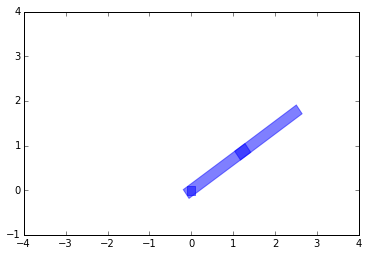

In [3]:
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 4))
m = [-1,0]
Box2DWorld.arm.gotoTargetJoints(m)
Box2DWorld.plotWorld(ax)
plt.show()



### Learning with Explauto

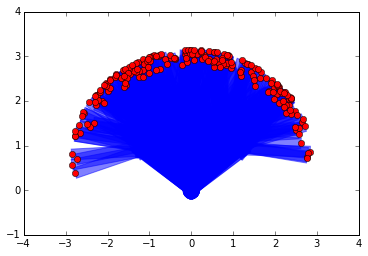

In [3]:
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 4))
positions = []
for i in range(200):
    t = [2*num-1 for num in np.random.rand(nparts)]
    Box2DWorld.arm.gotoTargetJoints(t)    
    endpos = Box2DWorld.arm.getFinalPos()
    model.update(t, endpos)
    positions.append(endpos)
    #plotting
    Box2DWorld.plotWorld(ax)
    ax.plot(*endpos, marker='o', color='red')


### Forward prediction Error

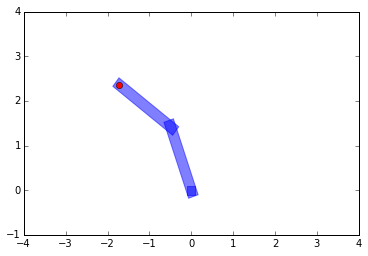

In [5]:
t = [2*num-1 for num in np.random.rand(nparts)]
Box2DWorld.arm.gotoTargetJoints(t)    
endpos = Box2DWorld.arm.getFinalPos()
pos_pred = model.forward_prediction(t)

fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 4))
Box2DWorld.plotWorld(ax)
ax.plot(*pos_pred, marker='o', color='red')
plt.show()

In [6]:
mse = 0
for i in range(100):
    t = [2*num-1 for num in np.random.rand(nparts)]
    Box2DWorld.arm.gotoTargetJoints(t)    
    endpos = Box2DWorld.arm.getFinalPos()
    jangles = Box2DWorld.arm.getJointAngles()
    
    pos_pred = model.forward_prediction(t)
    
    if(i<1):
        print "Joint angles: ", jangles
        print "End position: ", endpos
        print "Forward Position Predicton : ", pos_pred

    mse +=  sum(abs(endpos-pos_pred))**2

print "\nTotal mse forward prediction : ", mse

Joint angles:  [-0.8862640261650085, 0.3276180624961853]
End position:  [2.0366759300231934, 2.347571611404419]
Forward Position Predicton :  [ 2.21184829  2.22702557]

Total mse forward prediction :  5.76333499271


### Inverse prediction Error

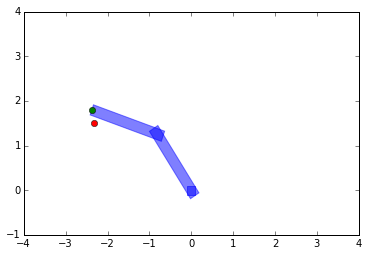

In [14]:
p = random.choice(positions)
jangles_pred = model.inverse_prediction(p)
Box2DWorld.arm.gotoTargetJoints(jangles_pred)    
endpos = Box2DWorld.arm.getFinalPos()

fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 4))
Box2DWorld.plotWorld(ax)
ax.plot(*p, marker='o', color='red')
ax.plot(*endpos, marker='o', color='green')
plt.show()

In [15]:
mse = 0
for i in range(100):
    p = random.choice(positions)
    jangles_pred = model.inverse_prediction(p)
    jangles_pred = np.clip(jangles_pred, -1, 1)
    Box2DWorld.arm.gotoTargetJoints(jangles_pred)    
    endpos = np.array(Box2DWorld.arm.getFinalPos())

    if(i<1):
        print "Position: ", p
        print "Inverse Joint Predicton : ", jangles_pred
        print endpos-p
        
    mse +=  sum(abs(p-endpos))**2

print mse

Position:  [-1.0249475240707397, 2.9415454864501953]
Inverse Joint Predicton :  [ 0.39402156 -0.13166214]
[-0.05646169  0.01284742]
5.98224832385
